In [1]:
from collections import Counter

dtype = {
    'Usage': 'category',
    'Description': 'category',
    'status': 'category',
}
df = pd.read_csv('data/reservations.csv.gz', dtype=dtype, parse_dates=['created', 'arrival', 'departure'])
df.drop(columns='Usage', inplace=True)

df.loc[df['cancel_date'] == '0001-01-01T00:00:00', ['cancel_date']] = None
df['cancel_date'] = pd.to_datetime(df['cancel_date'])

df['arrival_year'] = df['arrival'].dt.year

In [2]:
appearances = {}
for contract_id in df['contract_id'].unique():
    subset_df = df.loc[df['contract_id'] == contract_id].sort_values(by=['arrival', 'created'])
    # save the last known state
    # fill in blanks for bad years
    # handle case where cancel year might come after a series of misses
    yearly_state = {arrival_year: status for (created, arrival_year, status) in subset_df[['created', 'arrival_year', 'status']].itertuples(index=False, name=None)}
    earliest = subset_df['arrival_year'].min()
    latest = min(subset_df['arrival_year'].max(), 2019)
    activity = [(year, yearly_state.get(year, 'no-show')) for year in range(earliest, latest + 1)]    
    if activity:
        resort_id = subset_df['resort_id'].values[0]
        appearances[str(contract_id)] = [resort_id] + activity

In [3]:
rows = []
for r in list(appearances.values()):
    resort_id, activity = r[0], r[1:]
    row = [None] * 5
    row[-len(activity):] = [s for year, s in activity]
    rows.append([resort_id] + row)

In [4]:
df = pd.DataFrame(rows, columns=['resort_id', 'year_2015', 'year_2016', 'year_2017', 'year_2018', 'year_2019'])

In [5]:
df.head()

,resort_id,year_2015,year_2016,year_2017,year_2018,year_2019
0,28,None,None,active,active,active
1,28,active,active,active,active,active
2,30,active,active,active,cancelled,cancelled
3,39,no-show,active,active,active,active
4,38,cancelled,active,cancelled,active,active


In [6]:
df.drop('resort_id', axis=1, inplace=True)

df.year_2015 = pd.Categorical(df.year_2015)
df['year_2015'] = df.year_2015.cat.codes

df.year_2016 = pd.Categorical(df.year_2016)
df['year_2016'] = df.year_2016.cat.codes

df.year_2017 = pd.Categorical(df.year_2017)
df['year_2017'] = df.year_2017.cat.codes

df.year_2018 = pd.Categorical(df.year_2018)
df['year_2018'] = df.year_2018.cat.codes

#df.year_2019 = pd.Categorical(df.year_2019)
#df['year_2019'] = df.year_2019.cat.codes

df.columns = [''] * len(df.columns)

In [7]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import plot_importance
from sklearn.metrics import roc_auc_score

In [8]:
X = df.values[:,:-1]
y = df.values[:, -1]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [10]:
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy:', accuracy)

Accuracy: 0.6675513946530258


In [14]:
y_prob = model.predict_proba(X_test)
auc = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")

print('AUC:', auc)

AUC: 0.7678660585317042


In [15]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      active       0.71      0.86      0.78     11582
   cancelled       0.61      0.51      0.55      5562
     no-show       0.51      0.29      0.37      3578

    accuracy                           0.67     20722
   macro avg       0.61      0.55      0.57     20722
weighted avg       0.65      0.67      0.65     20722



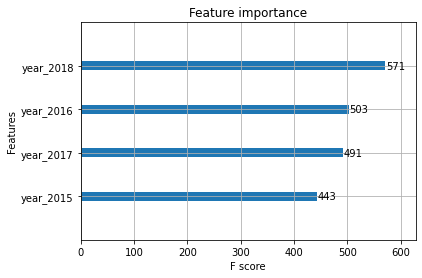

In [17]:
model.get_booster().feature_names = ['year_2015', 'year_2016', 'year_2017', 'year_2018']
plot_importance(model.get_booster());

In [18]:
model = XGBClassifier()
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["merror", "mlogloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-merror:0.3396	validation_0-mlogloss:1.05477	validation_1-merror:0.339301	validation_1-mlogloss:1.05502
[1]	validation_0-merror:0.34142	validation_0-mlogloss:1.01778	validation_1-merror:0.34099	validation_1-mlogloss:1.01841
[2]	validation_0-merror:0.34142	validation_0-mlogloss:0.986663	validation_1-merror:0.34099	validation_1-mlogloss:0.987349
[3]	validation_0-merror:0.34142	validation_0-mlogloss:0.960197	validation_1-merror:0.34099	validation_1-mlogloss:0.96085
[4]	validation_0-merror:0.34142	validation_0-mlogloss:0.937143	validation_1-merror:0.34099	validation_1-mlogloss:0.938186
[5]	validation_0-merror:0.34142	validation_0-mlogloss:0.917799	validation_1-merror:0.34099	validation_1-mlogloss:0.918738
[6]	validation_0-merror:0.34142	validation_0-mlogloss:0.901054	validation_1-merror:0.34099	validation_1-mlogloss:0.901939
[7]	validation_0-merror:0.34142	validation_0-mlogloss:0.8865	validation_1-merror:0.34099	validation_1-mlogloss:0.887359
[8]	validation_0-merror:0.34142

[67]	validation_0-merror:0.332651	validation_0-mlogloss:0.782833	validation_1-merror:0.332497	validation_1-mlogloss:0.783534
[68]	validation_0-merror:0.332651	validation_0-mlogloss:0.782839	validation_1-merror:0.332497	validation_1-mlogloss:0.783478
[69]	validation_0-merror:0.332651	validation_0-mlogloss:0.782821	validation_1-merror:0.332497	validation_1-mlogloss:0.783481
[70]	validation_0-merror:0.332651	validation_0-mlogloss:0.782844	validation_1-merror:0.332497	validation_1-mlogloss:0.783472
[71]	validation_0-merror:0.332651	validation_0-mlogloss:0.782854	validation_1-merror:0.332497	validation_1-mlogloss:0.783417
[72]	validation_0-merror:0.332651	validation_0-mlogloss:0.782854	validation_1-merror:0.332497	validation_1-mlogloss:0.783407
[73]	validation_0-merror:0.332651	validation_0-mlogloss:0.782753	validation_1-merror:0.332497	validation_1-mlogloss:0.783351
[74]	validation_0-merror:0.332485	validation_0-mlogloss:0.782701	validation_1-merror:0.332352	validation_1-mlogloss:0.78333
[

XGBClassifier(objective='multi:softprob')

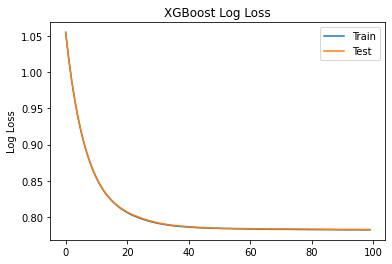

In [19]:
results = model.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show();

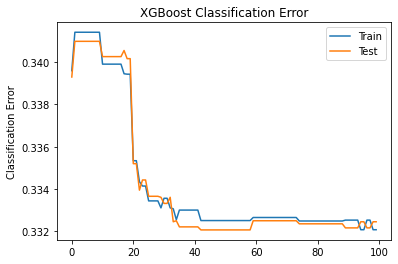

In [21]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show();